In [1]:
import warnings
warnings.simplefilter('ignore')

import gc
import re
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from tqdm.auto import tqdm

## Get Session Info

In [2]:
df_sess = pd.read_csv('sessions_train.csv')
df_sess = df_sess[df_sess['locale']=='UK'][:5000]

In [4]:
def str2list(x):
    x = x.replace('[', '').replace(']', '').replace("'", '').replace('\n', ' ').replace('\r', ' ')
    l = [i for i in x.split() if i]
    return l

In [5]:
next_item_dict = defaultdict(list)

for _, row in tqdm(df_sess.iterrows(), total=len(df_sess)):
    prev_items = str2list(row['prev_items'])
    next_item = row['next_item']
    prev_items_length = len(prev_items)
    if prev_items_length <= 1:
        next_item_dict[prev_items[0]].append(next_item)
    else:
        for i, item in enumerate(prev_items[:-1]):
            next_item_dict[item].append(prev_items[i+1])
        next_item_dict[prev_items[-1]].append(next_item)

100%|████████████████████████████████████| 5000/5000 [00:00<00:00, 20546.68it/s]


In [6]:
# next_item_dict

In [9]:
k = []
v = []

for item in next_item_dict:
    k.append(item)
    v.append(next_item_dict[item])
    
df_next = pd.DataFrame({'item': k, 'next_item': v})
df_next = df_next.explode('next_item').reset_index(drop=True)
df_next

,item,next_item
0,B0BFDL54Y7,B0BFDR9X13
1,B0BFDR9X13,B07J4WF8VH
2,B07J4WF8VH,B07Y21LDJX
3,B07Y21LDJX,B07Y227WNJ
4,B07FM2GLNQ,B07GZW3P4W
...,...,...
35770,B0813XRBQG,B000J69D12
35771,B08MW1FYMT,B07XV9Q6VR
35772,B07XV9Q6VR,B0B47JKF4V
35773,B0B47JKF4V,B09GSHBNBL


In [10]:
df_next.head()

,item,next_item
0,B0BFDL54Y7,B0BFDR9X13
1,B0BFDR9X13,B07J4WF8VH
2,B07J4WF8VH,B07Y21LDJX
3,B07Y21LDJX,B07Y227WNJ
4,B07FM2GLNQ,B07GZW3P4W


In [12]:
dt = df_next[['item', 'next_item']].value_counts().to_frame().rename(columns={0: 'weight'}).reset_index()

In [14]:
dt.head()

,item,next_item,weight
0,B08PKLFM9T,B08F2NDB39,14
1,B077L4Y11C,B076VDGMNR,10
2,B08KFHDPY9,B0851KN668,10
3,B07KWYGTC6,B07KX2N355,10
4,B076VDGMNR,B07H796FNF,9


## Combine Session Info with Product Info

In [15]:
products_final = pd.read_csv('products_final.csv', index_col='id')

In [16]:
combined_embeddings = np.column_stack([products_final[i].values for i in products_final.columns])
df = pd.DataFrame()
df['item'] = products_final.index
df['combined_embedding_pca'] = list(combined_embeddings)
df

,item,combined_embedding_pca
0,B087LZNPHS,"[-3.710657061456801, -1.025127521970962, 1.805..."
1,B08THFN1KX,"[3.531190102123368, -0.287150815463147, -4.571..."
2,0804185328,"[2.479327673821289, 1.451876744354406, -0.1092..."
3,B09VBKDBW6,"[-5.30176462978552, -4.888179697359907, 1.6169..."
4,B096ZW8B49,"[-3.7725240459994938, -4.362319394307887, -0.2..."
...,...,...
500175,B08D7KW8VK,"[-0.9095080516963407, 3.904827590015609, -0.54..."
500176,B073WXLXR9,"[-1.2420813271672726, 2.749905047185215, 0.423..."
500177,1529393833,"[0.6665658885712296, 3.454192941457756, -2.589..."
500178,B0B3TJ1NDN,"[-3.0103758034940262, -8.528207777914872, -8.7..."


In [17]:
da = dt.merge(df, how = 'left', on='item')
da = da.merge(df, how = 'left', left_on='next_item', right_on='item')

In [18]:
da = da[['item_x', 'next_item', 'weight', 'combined_embedding_pca_x', 'combined_embedding_pca_y']]
da = da.rename(columns={'item_x':'source', 'next_item':'target', 'combined_embedding_pca_x':'combined_embedding_pca_source', 'combined_embedding_pca_y':'combined_embedding_pca_target'})

In [19]:
da.isna().sum()/len(da)

source                           0.0
target                           0.0
weight                           0.0
combined_embedding_pca_source    0.0
combined_embedding_pca_target    0.0
dtype: float64

In [20]:
da.head()

,source,target,weight,combined_embedding_pca_source,combined_embedding_pca_target
0,B08PKLFM9T,B08F2NDB39,14,"[-3.120695662833671, -6.146007960367222, -7.79...","[-3.4228145131627654, -6.306702157690336, -8.5..."
1,B077L4Y11C,B076VDGMNR,10,"[-1.6692556350296754, -1.653358887883875, 4.11...","[-0.4923145732807215, -0.5783600297859872, 3.9..."
2,B08KFHDPY9,B0851KN668,10,"[-1.708719452109281, 1.926557962126049, -0.766...","[-2.290786403918072, 2.010306986476631, 0.7234..."
3,B07KWYGTC6,B07KX2N355,10,"[5.123140007690672, -4.3068939649221, -3.17537...","[-0.7992513296289626, -2.328350773585829, -3.7..."
4,B076VDGMNR,B07H796FNF,9,"[-0.4923145732807215, -0.5783600297859872, 3.9...","[-1.7567443421042368, -0.8689013160611473, 3.7..."


In [21]:
db = pd.DataFrame()
db['item'] = list(set(da['source'].to_list()+da['target'].to_list()))
db = db.merge(df, how='left', on='item')
db

,item,combined_embedding_pca
0,B09YV4HHH5,"[-0.7065882875062616, -4.408824520787836, 0.33..."
1,B0BJVV5QSH,"[2.086517517278732, 6.101709384514594, -4.0123..."
2,B06XWXTF9R,"[-3.5996432792393542, -2.652594458802295, 4.16..."
3,B083XRZK74,"[-4.479795778495036, -3.3648137219222405, 0.81..."
4,B08HYSF5M9,"[2.193212083037213, -2.3710343028983902, -3.34..."
...,...,...
31084,B003WK62OS,"[0.6386586669152398, -4.562024317699217, -3.27..."
31085,B07Z3FSKST,"[-7.5070731895445215, 7.895087799163001, -1.02..."
31086,B000TAY03O,"[14.967140288431942, -1.8607484386280704, 0.51..."
31087,B087LSZF4M,"[-3.858864851286965, 4.7188834415505205, -1.18..."


In [33]:
combined_embeddings_pca_source = np.array([da['combined_embedding_pca_source'][i] for i in range(len(da))])
combined_embeddings_pca_target = np.array([da['combined_embedding_pca_target'][i] for i in range(len(da))])

## GNN

In [34]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [35]:
import torch
from torch_geometric.data import Data
# Create node features tensor
x = torch.tensor(combined_embeddings_pca_source, dtype=torch.float)
y = torch.tensor(combined_embeddings_pca_target, dtype=torch.float)

# Create dictionary mapping node labels to node indices
node_indices = {node_label: i for i, node_label in enumerate(set(da['source']).union(set(da['target'])))}


# Create matrix of edge indices
edge_indices = torch.tensor([(node_indices[source], node_indices[target]) for source, target in zip(da['source'], da['target'])], dtype=torch.long).t()

# Create tensor of edge weights
edge_weights = torch.tensor(da['weight'].values, dtype=torch.float)

# Create PyTorch Geometric Data object with edge weights
data = Data(x=x, edge_index=edge_indices, edge_attr=edge_weights)

data.y = y


In [36]:
data

Data(x=[32655, 448], edge_index=[2, 32655], edge_attr=[32655], y=[32655, 448])

In [37]:
num_nodes = data.num_nodes
indices = torch.arange(num_nodes)
shuffled_indices = torch.randperm(num_nodes)

train_indices = shuffled_indices[:int(num_nodes * 0.6)]
val_indices = shuffled_indices[int(num_nodes * 0.6):int(num_nodes * 0.8)]
test_indices = shuffled_indices[int(num_nodes * 0.8):]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = 1

val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[val_indices] = 1

test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[test_indices] = 1

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [38]:
data

Data(x=[32655, 448], edge_index=[2, 32655], edge_attr=[32655], y=[32655, 448], train_mask=[32655], val_mask=[32655], test_mask=[32655])

In [39]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Define the GCN model for regression
class GCNRegression(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNRegression, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [40]:
# Define the training loop
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [41]:
# Load the data and model, and train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = GCNRegression(data.num_node_features, 256, data.num_node_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
losses=[]
for epoch in range(1, 201):
    loss = train(model, optimizer, data)
    losses.append(loss)
    if epoch%10==0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

Epoch 10, Loss: 2.0130
Epoch 20, Loss: 1.9434
Epoch 30, Loss: 1.8769
Epoch 40, Loss: 1.8388
Epoch 50, Loss: 1.8145
Epoch 60, Loss: 1.7980
Epoch 70, Loss: 1.7860
Epoch 80, Loss: 1.7770
Epoch 90, Loss: 1.7700
Epoch 100, Loss: 1.7643
Epoch 110, Loss: 1.7596
Epoch 120, Loss: 1.7556
Epoch 130, Loss: 1.7523
Epoch 140, Loss: 1.7494
Epoch 150, Loss: 1.7470
Epoch 160, Loss: 1.7451
Epoch 170, Loss: 1.7433
Epoch 180, Loss: 1.7417
Epoch 190, Loss: 1.7402
Epoch 200, Loss: 1.7394


findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


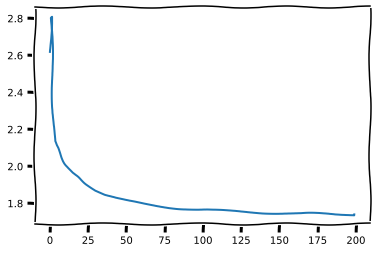

In [42]:
import matplotlib.pyplot as plt
with plt.xkcd():
    plt.plot(losses)

In [43]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    test_loss = F.mse_loss(out[data.test_mask], data.y[data.test_mask])
    print(f'Test Loss: {test_loss:.4f}')

Test Loss: 1.8905
